# Import data

In [1]:
import tensorflow as tf
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
import numpy as np

ins_df = pd.read_csv('data/instagram_data.csv')
ins_df = ins_df[ins_df['Contents'].notna()] # We might want to do something different here - SN
ins_df

,imagename,postid,dataset,dataset.1,postdate,Contents,url,Q1_pertain_to_covid,Q2_cetegory,Q2A_Type of Human,...,Q8_threat_covid,Q9_susceptibility_covid,Q9A_Asian responsible for the covid,Q10_solution_present,Q11_recommended_solution,misinformation,Q12 Presence of conspiracy theory,Q12-Others,Q13. Image of plague doctor costume,Note
0,B-A5FIIIEKJ,5592,middle,2,3/21/20,#covid #covid2020 #covidvirus #virus #coronava...,https://www.instagram.com/p/B-A5FIIIEKJ/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,Stay home
1,B-A74YQn_4a,5593,middle,2,3/21/20,Well this is the final mural of my trip in Aus...,https://www.instagram.com/p/B-A74YQn_4a/,1,1,1,...,1,1,2,2,99,0,2,99,2.0,NaN
2,B-AajnDp6GQ,5575,middle,2,3/21/20,Chegamos !!! Vão seguindo o movimento... Tem m...,https://www.instagram.com/p/B-AajnDp6GQ/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
3,B-AarR4pUQA,5576,middle,2,3/21/20,😻😻😻😻😻,https://www.instagram.com/p/B-AarR4pUQA/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
4,B-AE1y3HD-Z,5550,middle,2,3/21/20,EN MI DOMICILIO 🏡\r\r\r\r\n#quedateencasa\r\r\...,https://www.instagram.com/p/B-AE1y3HD-Z/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,mask; Stay home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,CEZyheBgtMd,8402,second,3,8/27/20,#water #foryou #followforfollowback #photograp...,https://www.instagram.com/p/CEZyheBgtMd/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9644,CEZYoyRluKG,8352,second,3,8/27/20,#like4likes #20likes #tagforlikes #instalikes ...,https://www.instagram.com/p/CEZYoyRluKG/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9645,CEZz-solaUF,8403,second,3,8/27/20,🙈🥰😍👉🏽 @love_serie_karma #daancorona #daancoron...,https://www.instagram.com/p/CEZz-solaUF/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9646,CEZZ4P4j3rh,8354,second,3,8/27/20,💥🚨 𝗙𝗔𝗟𝗟 𝗜𝗦 𝗖𝗢𝗠𝗜𝗡𝗚 🚨💥⁣\r\r\r\r\r\n⁣\r\r\r\r\r\n...,https://www.instagram.com/p/CEZZ4P4j3rh/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN


In [3]:
from sklearn.utils import shuffle

anger_df = pd.read_csv('data/twitter/anger.tsv', sep='\t').drop(columns=['index', 'intensity'])
fear_df = pd.read_csv('data/twitter/fear.tsv', sep='\t').drop(columns=['index', 'intensity'])
joy_df = pd.read_csv('data/twitter/joy.tsv', sep='\t').drop(columns=['index', 'intensity'])
sadness_df = pd.read_csv('data/twitter/sadness.tsv', sep='\t').drop(columns=['index', 'intensity'])

emotion_df = pd.concat([anger_df, fear_df, joy_df, sadness_df])
emotion_df = shuffle(emotion_df)

emotion_df

,tweet,category
356,never #make a decision when you are .. #angry ...,anger
683,@JoeGoodmanJr. A solution. But the assumptions...,anger
698,"Meanwhile, the so-called Mâ€™s fans sit there ...",joy
56,"What a great training course, lots of photos, ...",joy
415,@KarenL109 replace the carpet!! #shocking !!!!,fear
...,...,...
733,@ChrisWarcraft The concept that a gay magazine...,fear
1042,81' Goal scorer Vidar Kjartansson comes off in...,fear
689,Back to forest drama -\nfrom my #Forest #music...,sadness
571,@alyssasimpson21 I gave up KENDRICK LAMAR to e...,anger


# Feature Engineering

In [4]:
!pip install --upgrade transformers datasets

Requirement already up-to-date: transformers in c:\users\hp\anaconda3\lib\site-packages (4.12.5)
Requirement already up-to-date: datasets in c:\users\hp\anaconda3\lib\site-packages (1.16.1)


In [5]:
import torch
from transformers import AutoTokenizer
# MODEL = "cardiffnlp/twitter-roberta-base-sentiment" 
MODEL = "roberta-base" # Will likely change
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Note: How we preprocess may depend on model we use to transfer. 
# This comes from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Load data into numpy arrays
X = np.array(emotion_df['tweet'])
Y = np.array(emotion_df['category'])
Y_ints = np.array(pd.factorize(emotion_df['category'])[0])
X_ins = np.array(ins_df['Contents'])
east_asian = np.array(ins_df['Q5A.  If yes to Q5, what type of Asian'] == 1, dtype=int)

# Preprocess text
for i in range(len(X)):     X[i] = preprocess(X[i])
for i in range(len(X_ins)): X_ins[i] = preprocess(X_ins[i])

# Split into train/val/test sets
TRAIN_PCT, VAL_PCT, TEST_PCT  = 0.6, 0.2, 0.2
train_idx = int(TRAIN_PCT * len(X))
val_idx = train_idx + int(VAL_PCT * len(X))

In [6]:
X_train, Y_train = X[:train_idx], Y_ints[:train_idx]
X_val, Y_val = X[train_idx:val_idx], Y_ints[train_idx:val_idx]
X_test, Y_test = X[val_idx:], Y_ints[val_idx:]

# Tokenize the data
X_train_enc = tokenizer(list(X_train), return_tensors='pt', padding=True, truncation=True)
X_val_enc = tokenizer(list(X_val), return_tensors='pt', padding=True, truncation=True)
X_test_enc = tokenizer(list(X_test), return_tensors='pt', padding=True, truncation=True)
X_ins_enc = tokenizer(list(X_ins), return_tensors='pt', padding=True, truncation=True)

# Model Definition

In [7]:
# TODO: define our machine learning model, from our discussion it we can try deep learning models

import os
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)

import math 
from transformers import  (
    BertPreTrainedModel, 
    RobertaConfig, 
    RobertaTokenizerFast
)

from transformers.optimization import (
    AdamW, 
    get_linear_schedule_with_warmup
)

from scipy.special import softmax
from torch.nn import CrossEntropyLoss

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    roc_curve,
    auc,
    average_precision_score,
    accuracy_score
)

from transformers.models.roberta.modeling_roberta import (
    RobertaClassificationHead,
    RobertaConfig,
    RobertaModel,
)

num_labels = 4

In [8]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('Number of GPUs: ',torch.cuda.device_count())
else:
    print('No GPU, using CPU.')
    device = torch.device("cpu")

Number of GPUs:  1


In [9]:
max_seq_length = 128 
train_batch_size = 8
test_batch_size = 8
warmup_ratio = 0.06
weight_decay=0.001
gradient_accumulation_steps = 1
num_train_epochs = 5 
learning_rate = 1e-05
adam_epsilon = 1e-08

In [10]:
class RobertaClassification(BertPreTrainedModel):
    
    def __init__(self, config):
        super(RobertaClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)
        
        
    def forward(self, input_ids, attention_mask, labels):
        outputs = self.roberta(input_ids,attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

config_class = RobertaConfig
model_class = RobertaClassification

config = config_class.from_pretrained(MODEL, num_labels=num_labels)
model = model_class.from_pretrained(MODEL, config=config)
print('Model=\n',model,'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this 

Model=
 RobertaClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [11]:
class MyClassificationDataset(Dataset):
    
    def __init__(self, data,y):
        text = data
        labels=y
        self.examples = text
#         targets = tr.transform(labels)
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        

    def __len__(self):
        return len(self.examples["input_ids"])

    def __getitem__(self, index):
        return {key: self.examples[key][index] for key in self.examples}, self.labels[index]

#X_train, Y_train = X[:train_idx], Y[:train_idx]
#X_val, Y_val = X[train_idx:val_idx], Y[train_idx:val_idx]
#X_test, Y_test = X[val_idx:], Y[val_idx:]

train_dataset = MyClassificationDataset(X_train_enc,Y_train)
val_dataset = MyClassificationDataset(X_val_enc, Y_val)
test_dataset = MyClassificationDataset(X_test_enc, Y_test)
ins_dataset = MyClassificationDataset(X_ins_enc, [-1.] * len(X_ins))

<ipython-input-11-946b6e0e6405>:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.labels = torch.as_tensor(labels, dtype=torch.long)


In [12]:
train_batch_size = 8
val_batch_size = 8
test_batch_size = 8

def get_inputs_dict(batch):
    inputs = {key: value.squeeze(1).to(device) for key, value in batch[0].items()}
    inputs["labels"] = batch[1].to(device)
    return inputs

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=val_batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size)

ins_sampler = SequentialSampler(ins_dataset)
ins_dataloader = DataLoader(ins_dataset, sampler=ins_sampler, batch_size=test_batch_size)

#Extract a batch as sanity-check
batch = get_inputs_dict(next(iter(train_dataloader)))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)

print(batch)

{'input_ids': tensor([[    0, 17762,    11,  ...,     1,     1,     1],
        [    0,  1039, 12105,  ...,     1,     1,     1],
        [    0, 48641,  2600,  ...,     1,     1,     1],
        ...,
        [    0,  4763,  9460,  ...,     1,     1,     1],
        [    0,   642, 11867,  ...,     1,     1,     1],
        [    0,  2527,   685,  ...,     1,     1,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([0, 0, 0, 2, 3, 3, 3, 3], device='cuda:0')}


In [13]:
t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
optimizer_grouped_parameters = []
custom_parameter_names = set()
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters.extend(
    [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if n not in custom_parameter_names and not any(nd in n for nd in no_decay)
            ],
            "weight_decay": weight_decay,
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if n not in custom_parameter_names and any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
)

warmup_steps = math.ceil(t_total * warmup_ratio)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

# Training

In [14]:
# TODO: train our model using the loaded data
model.to(device)

model.zero_grad()

def log_metrics(y, y_preds):
    print(classification_report(y, y_preds, target_names=['Joy', 'Fear', 'Sadness', 'Anger']))
    

def train_epochs(num_train_epochs):
    avg_loss=[]
    avg_val_loss=[]
    for epoch in range(num_train_epochs):

        model.train()
        epoch_loss = []
    
        for batch in train_dataloader:
            batch = get_inputs_dict(batch)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            epoch_loss.append(loss.item())
        
        #evaluate model with test_df at the end of the epoch.
        eval_loss = 0.0
        nb_eval_steps = 0
        n_batches = len(val_dataloader)
        preds = np.empty((len(val_dataset), num_labels))
        out_label_ids = np.empty((len(val_dataset)))
        model.eval()
    
        for i,test_batch in enumerate(val_dataloader):
            with torch.no_grad():
                test_batch = get_inputs_dict(test_batch)
                input_ids = test_batch['input_ids'].to(device)
                attention_mask = test_batch['attention_mask'].to(device)
                labels = test_batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                tmp_eval_loss, logits = outputs[:2]
                eval_loss += tmp_eval_loss.item()
            
            nb_eval_steps += 1
            start_index = test_batch_size * i
            end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
            preds[start_index:end_index] = logits.detach().cpu().numpy()
            out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()
        
        eval_loss = eval_loss / nb_eval_steps
        model_outputs = preds
        preds = np.argmax(preds, axis=1)
        #result, wrong = compute_metrics(preds, model_outputs, out_label_ids)
        epoch_loss=np.mean(epoch_loss)
        print('epoch',epoch,'Training avg loss',epoch_loss)
        print('epoch',epoch,'Testing  avg loss',eval_loss)
        print('---------------------------------------------------\n')
        avg_loss.append(epoch_loss)
        avg_val_loss.append(eval_loss)
    report=log_metrics(Y_val, preds)
    print(report)
    avg_loss=np.mean(avg_loss)
    avg_val_loss=np.mean(avg_val_loss)
    accuracy=accuracy_score(Y_val, preds)
    return avg_loss,avg_val_loss,report,accuracy
        

# Performance Evaluation

In [15]:
# TODO: evaluate using accuracy to see how well our model is performing on the test set
# Report the approach(es) you take for each of this task and your multi-class accuracy and 
#   per-class precision and recall for each emotion class (fear, anger, joy, and sadness) on the development set.



In [16]:
def test():   
    model.to(device)
    eval_loss = 0.0
    nb_eval_steps = 0
    n_batches = len(test_dataloader)
    preds = np.empty((len(test_dataset), num_labels))
    out_label_ids = np.empty((len(test_dataset)))
    model.eval()
    for i,test_batch in enumerate(test_dataloader):
        with torch.no_grad():
            test_batch = get_inputs_dict(test_batch)
            input_ids = test_batch['input_ids'].to(device)
            attention_mask = test_batch['attention_mask'].to(device)
            labels = test_batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.item()

        nb_eval_steps += 1
        start_index = test_batch_size * i
        end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
        preds[start_index:end_index] = logits.detach().cpu().numpy()
        out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()

    eval_loss = eval_loss / nb_eval_steps
    model_outputs = preds
    preds = np.argmax(preds, axis=1)
    print("classification report for test set")
    print(log_metrics(Y_test, preds))
    accuracy=accuracy_score(Y_test, preds)
    return eval_loss,accuracy

In [17]:
train_loss=[]
val_loss=[]
val_acc=[]
test_loss=[]
test_acc=[]
for epoch in range(2,12,2):
    print("train with epochs=",epoch)
    avg_loss,avg_val_loss,report,accuracy=train_epochs(2)
    train_loss.append(avg_loss)
    val_loss.append(avg_val_loss)
    val_acc.append(accuracy)
    testloss,testacc=test()
    test_loss.append(testloss)
    test_acc.append(testacc)

train with epochs= 2
epoch 0 Training avg loss 1.2790201891392359
epoch 0 Testing  avg loss 0.7979225761942811
---------------------------------------------------

epoch 1 Training avg loss 0.6456484510339934
epoch 1 Testing  avg loss 0.549698912344136
---------------------------------------------------

              precision    recall  f1-score   support

         Joy       0.72      0.84      0.77       152
        Fear       0.91      0.89      0.90       175
     Sadness       0.79      0.84      0.81       237
       Anger       0.83      0.66      0.73       158

    accuracy                           0.81       722
   macro avg       0.81      0.80      0.80       722
weighted avg       0.81      0.81      0.81       722

None
classification report for test set
              precision    recall  f1-score   support

         Joy       0.71      0.85      0.77       162
        Fear       0.93      0.90      0.92       168
     Sadness       0.78      0.80      0.79       235
  

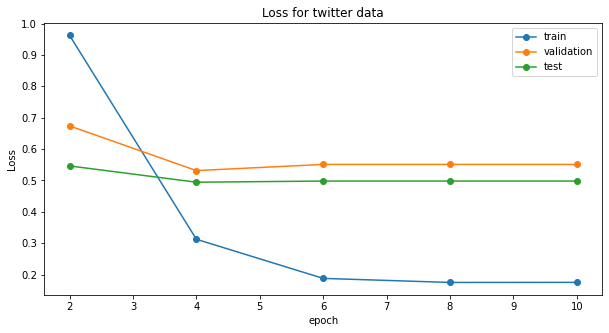

In [24]:
import matplotlib.pyplot as plt

x=[2,4,6,8,10]
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Loss for twitter data")
plt.plot(x,train_loss,marker='o',label='train')
plt.plot(x,val_loss,marker='o',label='validation')
plt.plot(x,test_loss,marker='o',label='test')
plt.legend()

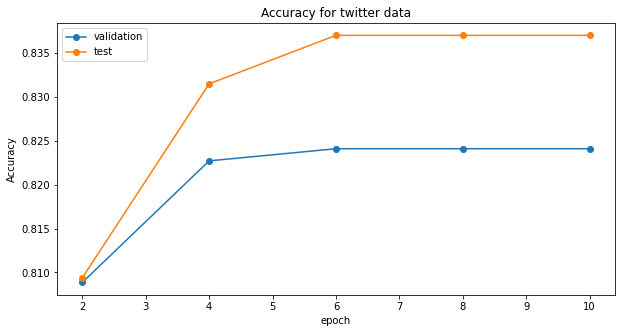

In [25]:
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy for twitter data")
plt.plot(x,val_acc,marker='o',label='validation')
plt.plot(x,test_acc,marker='o',label='test')
plt.legend()

# Prediction

In [18]:
# TODO: predict the submission data 
model.to(device)
nb_eval_steps = 0
n_batches = len(ins_dataloader)
preds = np.empty((len(ins_dataset), num_labels))
model.eval()
    
for i,test_batch in enumerate(ins_dataloader):
    with torch.no_grad():
        test_batch = get_inputs_dict(test_batch)
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, logits = outputs[:2]

    nb_eval_steps += 1
    start_index = test_batch_size * i
    end_index = start_index + test_batch_size if i != (n_batches - 1) else len(ins_dataset)
    preds[start_index:end_index] = logits.detach().cpu().numpy()

eval_loss = eval_loss / nb_eval_steps
model_outputs = preds
preds = np.argmax(preds, axis=1)

np.savetxt('instagram_predictions.txt', preds) # We might want to do something different here - SN

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
from scipy.stats import pearsonr
# from scipy.stats import spearmanr
emotions = ['Joy', 'Fear', 'Sadness', 'Anger']

for i in range(num_labels):
    corr, _ = pearsonr(preds[:,i], east_asian)
    print('Correlation with {}: {}'.format(emotions[i], corr))